## This is a notebook dedicated to looking into audio analysis in python and features for music information retrieval
### Ideally these will be used to later on music genre classification 

Move to bottom when done but sources:

https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

https://musicinformationretrieval.com/index.html

In [2]:
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import sklearn

## Reading an audio signal

In [3]:
audio_path='JinsangAffection.mp3'

time_series, sample_rate = librosa.load(audio_path)

print(type(time_series), type(sample_rate))
print(time_series.shape, sample_rate)

stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))

/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


<class 'numpy.ndarray'> <class 'int'>
(2650112,) 22050


This returns x and sr

x : is a time series that represents a 1D ndarray of floats. the floats correspond to the amplitube of the waveform at t.

sr : is the samples recorded per second

#### Display information about audio signal, show waveform, and create player

Sr (samples recorded): 22050  x.shape:  (2650112,)  x.dtype:  float32
seconds:  120.18648526077098


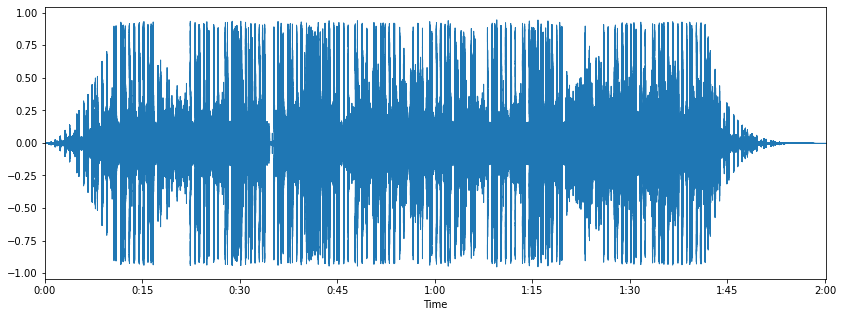

In [6]:
def print_plot(x, sr):
    print('Sr (samples recorded):', sr, " x.shape: ", x.shape, " x.dtype: ", x.dtype)
    print("seconds: ", x.shape[0]/sr)
    plt.figure(figsize=(14,5))
    librosa.display.waveplot(x, sr=sr)
    ipd.display(ipd.Audio(data=x, rate=sr))
    
print_plot(time_series, sample_rate)
x = time_series
sr = sample_rate

### Spectogram

we can also create a spectogram off the song. 

A spectogram is a visual representation of frequencies of sound or other signals that vary with time.

##### Explained methods:

**librosa.stft()** - this does a fourier transformation on the audio file, the fourier transform basically takes our waveform and transforms it to the frequency domain. 

**librosa.amplitude_to_db()** - this converts the amplitude to be scaled by decibels which limits the numerical range and is logarithimic (more aligned with how we hear sound opposed to linear) so the intensity of colors plotted is more related to how we hear

**librosa.display.specshow** display a spectogram for display

(2650112,)
(1025, 5177)
(1025, 5177)


(5177,)

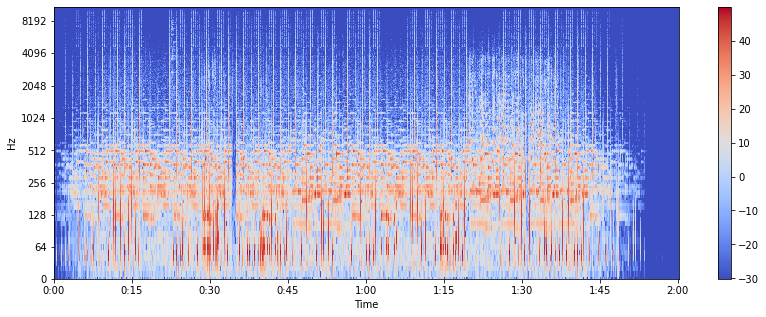

In [18]:
print(x.shape)
X = librosa.stft(x)
print(X.shape)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb.shape)
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
Xdb.sum(axis=0).shape

[ 468  469  529  530  591  652  653  714  715  960  961 1022 1083 1084
 1145 1206 1207 1268 1329 1391 1452 1453 1514 1575 1576 1637 1698 1699
 1760 1761 1822 1883 1944 1945 2006 2067 2068 2129 2130 2190 2191 2252
 2313 2314 2437 2498 2499 2560 2621 2683 2929 2990 2991 3052 3113 3114
 3175 3176 3237 3298 3299 3360 3421 3422 3729 3790 3791 3852 3913 3914
 3975 4036 4037 4098 4159 4160 4221 4282 4283 4344]


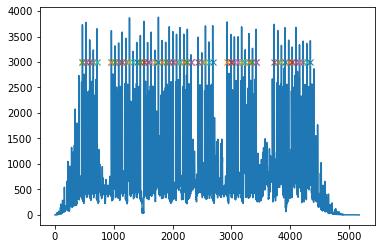

In [38]:
Xabs = np.abs(X)
peak_ind = np.where(Xabs.sum(axis=0) > 3000, )
plt.plot(np.arange(Xdb.shape[1]), np.abs(X).sum(axis=0))
plt.plot(peak_ind, np.ones(len(peak_ind))*3000, "x")
print(peak_ind[0])


In [14]:
frequencies = librosa.core.fft_frequencies(n_fft=2048*4)  # getting an array of frequencies
print(frequencies.shape)


# getting an array of time periodic
times = librosa.core.frames_to_time(np.arange(Xdb.shape[1]), sr=sample_rate, hop_length=512, n_fft=2048*4)
print(times.shape)

time_index_ratio = len(times)/times[len(times) - 1]
print(time_index_ratio)
frequencies_index_ratio = len(frequencies)/frequencies[len(frequencies)-1]
print(frequencies_index_ratio)

(4097,)
(5177,)
43.00825330946181
0.37160997732426304


## Feature extraction

#### But first some notes on the features I will be using for music information retrieval
    
__zero crossing rate__ - this is the rate of sign changes of a signal across positive or negative. higher values are normally more percussive sounds like ones in metal or rock.
        - calculate with librosa.zero_crossings
        
**spectral centroid** - this is the weighted mean of a spectrum. in this case we are looking at a spectrum of frequencies after the fourier transform so the spectral centroid will lie in the average frenquency.
        - compute this using librosa.feature.spectral_centroid

**spectral rolloff** - said to be the frequency under a pecentage (cutoff) of the total energy of the spectrum is contained. This is usally 85%. Can be used to distinguish harmoic sounds (below rolloff) and noisey sounds (above rolloff)

**Mel-Frequency cepstrum** - "Coefficients of a signal that describe the overall shape of a spectral envelope". They are scaled to coincide with the human auditory system (nonlinear) and the charateristics of human voice. 

**Chroma Freqencies** - a representation fro music audio in which the spectrum is projected into 12 different bins representing the 12 distinct chroma of musical octave. 

### Zero Crossing Rate

(1, 869)


Text(0.5, 1.0, 'Zero-Crossing rate vs Time')

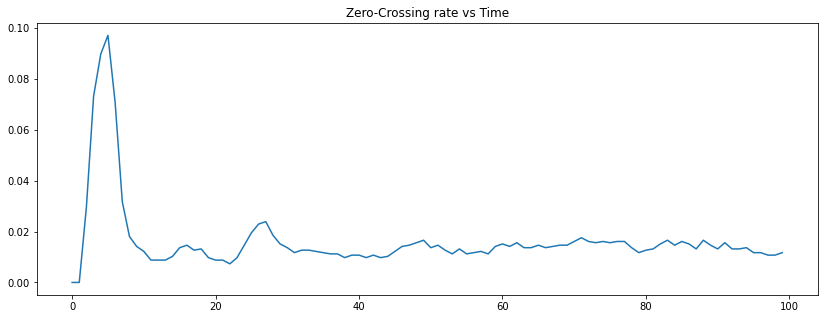

In [5]:
zero_crossing = librosa.feature.zero_crossing_rate(x)
print(zero_crossing.shape)
plt.figure(figsize=(14, 5))
plt.plot(zero_crossing[0][:100])
plt.title("Zero-Crossing rate vs Time")

This does not appear to be true in my case but sometimes the reason for the high zero crossing rate in the begining is because the silence oscilates quietly around zero. 

This can be avoided by adding a small constant before computing:

Text(0.5, 1.0, 'Zero-Crossing rate vs Time')

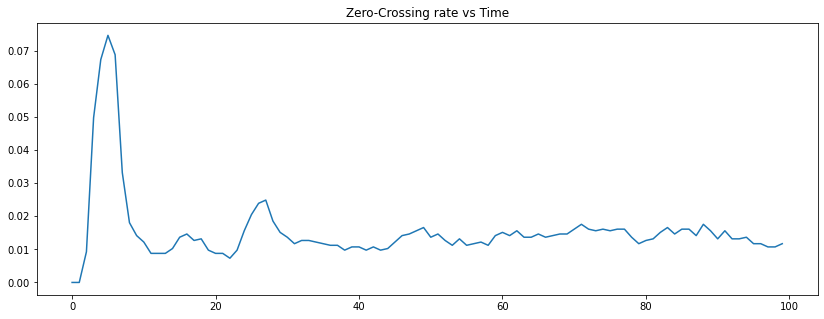

In [6]:
zero_crossing = librosa.feature.zero_crossing_rate(x+.0001)
plt.figure(figsize=(14, 5))
plt.plot(zero_crossing[0][:100])
plt.title("Zero-Crossing rate vs Time")

### Spectral Centroid

(869,)


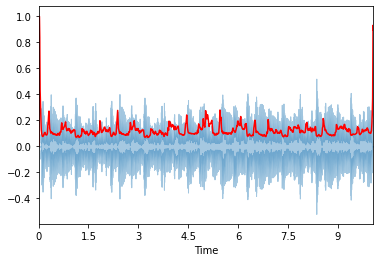

In [8]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(spectral_centroids.shape)

#compute time variable for plot
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sr)

spec_normed = sklearn.preprocessing.minmax_scale(spectral_centroids, axis=0)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, spec_normed, color='r')

### Spectral Rolloff

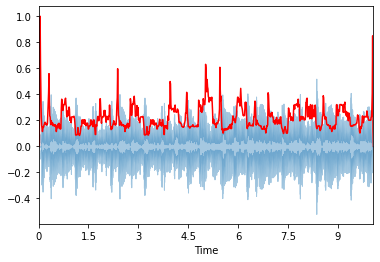

In [10]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+.001, sr=sr)[0]
roll_normed = sklearn.preprocessing.minmax_scale(spectral_rolloff, axis=0)
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, roll_normed, color='r')

### Mel-Frequency cepstrum

(20, 869)


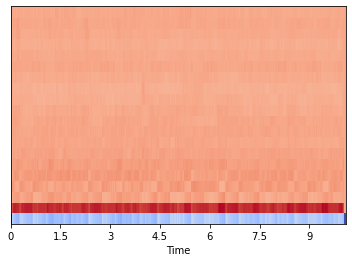

In [12]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma Frequencies

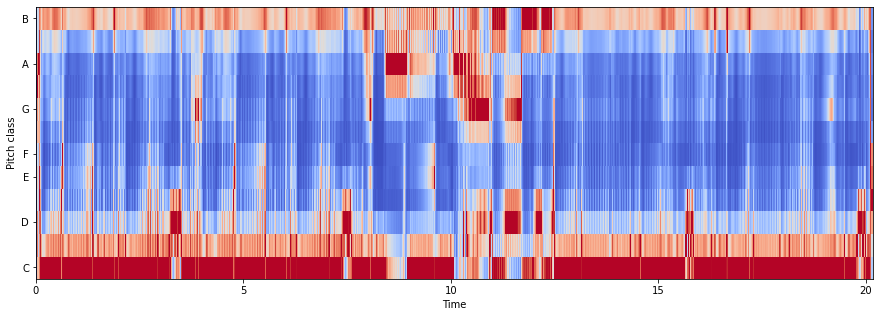

In [16]:
# Loadign the file
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')